# **Распознавание дорожных знаков. Задача классификации**

### Постановка задачи

  В данной работе будет произведено обучение нейросети для прогнозирования определения дорожных знаков. Эти знаки могут принадлежать 4м различным классом. В данном конкретном случае не имеет принципиального значения классификация, так как для реального определения дорожных знаков по типам, необходимы большие вычислительные мощности, длительное время и наиболее полный датасет.

  Эти знаки могут принадлежать четырем различным классам:  
* Круглая рамка основных предупреждений
* Квадратная рамка основных предупреждений
* Информационные сообщения различной формы
* Оповещения о наличии в близости указанных мест
* Небольшие таблички дополнительного содержания


### Датасет

Датасет состоит из 35000 изображения и 5 классов. Это большой, но специфически распределенный набор изображений. Большинство изображений относится к дополнительным информационным данным. 

### Загрузка данных

Все изображения представлены форматов png, набор данных разбит на папки train и test(validation). Каждая из этих папок имет 5 вложенных папок по одному на каждого типа знака. Изображения имеют различные цвета, фоны. 

# **Импорт библиотек и загрузка необходимых модулей**

In [70]:
import numpy as np
import pandas as pd
#from numba import jit, cuda 
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
import tensorflow as tf
from tensorflow import keras

In [72]:
#Включение дебаггинга при необходимости
#tf.debugging.set_log_device_placement(True)

In [73]:
# Проверка на доступность tensorflow GPU/ т.к обучение происходит на локальном компьютере с использованием CUDA\CUDNN
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [74]:
# Клонирование репо при необходимости
#!git clone https://github.com/.....

In [75]:
# Keras предлагает специальную функцию для загрузки изображений - load_img
from tensorflow.keras.preprocessing.image import load_img

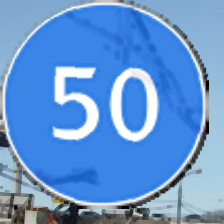

In [76]:
# Воспользуемся функцией для отображения тестового изображения
path = 'C:/Users/dj_ar/OneDrive/Рабочий стол/GB_AI/2 Project/dataset AI/train/4'
name = '4_0.png'
fullname = path + '/' + name
load_img(fullname)

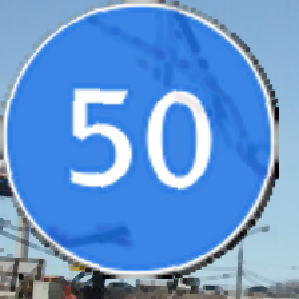

In [78]:
# Для изменения изображения пользуемся функцией target_size
load_img(fullname, target_size=(299, 299))

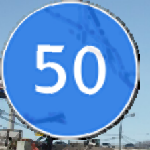

In [79]:
load_img(fullname, target_size=(150, 150))

*Обучение сверточной сети с нуля довольно трудоёмкий процесс, требующий  большого объема данных и мощного оборудования. Работа с большими объемами данных, такими как ImageNet (14 млн изображений), может потребовать недель непрерывного обучения.*

In [80]:
from tensorflow.keras.applications.xception import Xception #импорт фактической модели
from tensorflow.keras.applications.xception import preprocess_input #функция подготовки изображения к использованию моделью
from tensorflow.keras.applications.xception import decode_predictions # функция для декодирования предсказания модели

In [81]:
# Загрузим модель, указываем 2 параметра weights - хотим использовать предварительно 
# обученную модель и input_shape - размер входных изображений
# Мы меняем изображения до размера 299X299 и каждое изображение имеет 3 канала - красный, зеленый и синий.  
model = Xception(
    weights='imagenet', #предварительно обученная модель ImageNet
    input_shape=(299, 299, 3)
)

In [82]:
# Протестируем изображение, которое мы загрузили ранее - на выходе видим 3 измерения: ширина, высота и количество каналов 
img = load_img(fullname, target_size=(299, 299)) # массив формы изображения
x = np.array(img)
x.shape

(299, 299, 3)

In [83]:
X = np.array([x]) #массив и количество изображений
X.shape

(1, 299, 299, 3)

# **Обучение и создание модели **

In [84]:
# Преобразуем изображение для работы с моделью (функция преобразования целых чисел от 0 до 255 в числа от -1 до 1)
X = preprocess_input(X)

In [85]:
# Для применения модели используем методо predict
pred = model.predict(X)

1/1 [==============================] - 1s 854ms/step


In [86]:
# Смотрим сам массив, он состоит из 1000 элементов)
pred.shape

(1, 1000)

In [87]:
# Выходные данные предварительно обученной модели Xception. 
# Модель Xception показывает принадлежит ли изображение к одному из тысячи классов, каждый элемент в массиве прогнозов 
# представляет вероятность принадлежности к одному из классов 
pred[0, 5]

0.00032753748

In [88]:
# На этом выводе мы может конкретно посмотреть к каким классом предварительно обученная модель соотнесла наше изображение.
decode_predictions(pred)

[[('n04258138', 'solar_dish', 0.47796366),
  ('n06794110', 'street_sign', 0.046027295),
  ('n04044716', 'radio_telescope', 0.012387285),
  ('n03249569', 'drum', 0.011433894),
  ('n04311174', 'steel_drum', 0.011057934)]]

# **Сверточные слои **

*Все нейронные сети организованы в слои. Мы берем изображение, пропускаем через все слои и получаем на выходе прогнозы. Обычно модель состоит из множества слоёв, например, модель Xception, использует 71 слой*

Для свёрточной нейронной сети наиболее важными являются:
 * свёрточные
 * плотные


  Свёрточныё слой это в общем виде набор фильтров - небольших изображений с простыми формами, вроде полос. Фильтры в предварительно обученных моделях уже готовы, при движении мы сравниваем движение фильтра с содержимым изображения под ним. При каждом сравнении записывается некоторая степень сходства. На выходе получается карта характеристик - массив с числами, где бОльшее число означает совпадение между фильтром и изображением, а малое - отсутствие совпадения. 
    ! Карта характеристик - результат применения фильтра к изображению !
  Один свёрточный слой состоит из множества фильтров, поэтому мы фактически получаем несколько карт характеристик - по одной для каждого фильтра.
  С каждым следующим слоем мы используем его выходные данные, как входные данные для следующего слоя. 

  Плотный слой - эти слои обрабатывают векторное представление изображения и переводят визуальные особенности в реальный класс(в нашем случае тип по классификации дорожных знаков). Для получения прогноза, необходимо, объединить признаки в x с вектором весов w, а затем применить сигмоидальную функцию взяв все компоненты вектора x и соединить с результатов т.е вероятностью прогноза конкретного класса. 

  Имея для прогнозирования 5 классов, мы получаем 5 элементов в выходном слое. Чтобы сделать прогноз выбираем тот, который получил наибольшую оценку.
  


In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [90]:
image_size = (150, 150)
batch_size = 32

In [92]:
# Генератор. Производим загрузку данных. Применяем функцию preprocess_input к каждому изображению.(Сообщаем ImageDataGenerator 
# как нужно предварительно обработать данные). На выходе получаем количество изображений найденных
# в обучающем наборе

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    'C:/Users/dj_ar/OneDrive/Рабочий стол/GB_AI/2 Project/dataset AI/train/',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 35000 images belonging to 5 classes.


In [93]:
# Повторяем процесс для проверочного набора данных

validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    'C:/Users/dj_ar/OneDrive/Рабочий стол/GB_AI/2 Project/dataset AI/test/',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 15000 images belonging to 5 classes.


In [94]:
# Создаём базовую модель, используя предварительно обученную Xception
base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False #Сохраняет только свёрточные слои
)

base_model.trainable = False # "Замораживаем" базовую модель, т.к попытка обучить базовую модель приведёт к уничтожению всех фильтров.

In [95]:
# Строим модель классификации дорожных знаков.

inputs = keras.Input(shape=(150, 150, 3)) # Входные изображения

base = base_model(inputs, training=False) # Использует base_model для извлечения высокоуровневых признаков
vector = keras.layers.GlobalAveragePooling2D()(base) # Извлекает векторное представление, преобразует выходные данные base_model в вектор
outputs = keras.layers.Dense(5)(vector)# Добавляет плотный слой размером 5 (по одному для каждого класса)

model = keras.Model(inputs, outputs) # Объединяет входные и выходные данные в модель keras

*Для нашего проекта мы будем использовать алгоритм оптимизации Adam - для большинства случаев его вполне достаточно. Он требует одного параметра - скорости обучения.*

In [96]:
# Создаём оптимизатор и устанавливаем learning_rate(скорость обучения). Скорость обучений важный параметр, 
# если мы поставим слишком большую, то сеть может упустить некоторые важные детали. Если установим слишком 
# низкую это может занять очень много
# времени, поэтому процесс обучения окажется неэффективным. 
# В пакете keras.loses содержится множество разнообразных оценок потерь. Самые важные для нас это: 
#  * BinaryCrossentropy - для обучения двоичного классификатора
#  * CategoricalCrossentropy - для обучения модели классификации с несколькими классами
#  * MeanSquaredError - для обучения регрессионной модели
learning_rate = 0.01

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [97]:
# Обучаем модель. Указываем 3 параметра: train_ds - набор данных для обучения; epochs - количество эпох, 
# проходов; validation_data - набор данных для проверок.
# На выходе мы получаем - скорость обучения, достоверность набора данных(следить чтобы модель не переобучилась),
#  потери при обучении и проверке.
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
1094/1094 [==============================] - 98s 87ms/step - loss: 0.2117 - accuracy: 0.9342 - val_loss: 0.3315 - val_accuracy: 0.9159
Epoch 2/5
1094/1094 [==============================] - 87s 80ms/step - loss: 0.1394 - accuracy: 0.9620 - val_loss: 0.2125 - val_accuracy: 0.9489
Epoch 3/5
1094/1094 [==============================] - 83s 76ms/step - loss: 0.1272 - accuracy: 0.9673 - val_loss: 0.1881 - val_accuracy: 0.9619
Epoch 4/5
1094/1094 [==============================] - 83s 76ms/step - loss: 0.1031 - accuracy: 0.9729 - val_loss: 0.2015 - val_accuracy: 0.9603
Epoch 5/5
1094/1094 [==============================] - 82s 75ms/step - loss: 0.1117 - accuracy: 0.9730 - val_loss: 0.2083 - val_accuracy: 0.9585


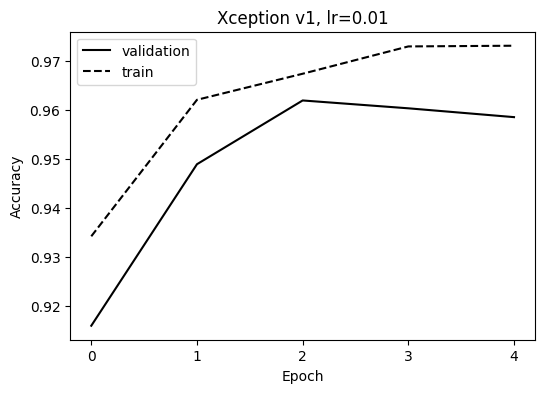

In [98]:
# Строим график точности на обучающем и проверочном наборе данных.Видно что модель довольно быстро
# достигает уровня 99%, уровень проверки также быстро растет.

plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(5))

plt.legend()


plt.savefig('xception_v1_0_01.svg')

plt.show()

In [99]:
# Пишем функцию для создания модели.

def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(5)(vector)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

In [100]:
# Пробуем разные значения обучения. 
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
1094/1094 [==============================] - 84s 75ms/step - loss: 0.2406 - accuracy: 0.9235 - val_loss: 0.1323 - val_accuracy: 0.9581
Epoch 2/5
1094/1094 [==============================] - 83s 76ms/step - loss: 0.1089 - accuracy: 0.9662 - val_loss: 0.0976 - val_accuracy: 0.9701
Epoch 3/5
1094/1094 [==============================] - 83s 76ms/step - loss: 0.0835 - accuracy: 0.9744 - val_loss: 0.0864 - val_accuracy: 0.9729
Epoch 4/5
1094/1094 [==============================] - 83s 76ms/step - loss: 0.0680 - accuracy: 0.9788 - val_loss: 0.0857 - val_accuracy: 0.9707
Epoch 5/5
1094/1094 [==============================] - 99s 90ms/step - loss: 0.0603 - accuracy: 0.9811 - val_loss: 0.0772 - val_accuracy: 0.9734


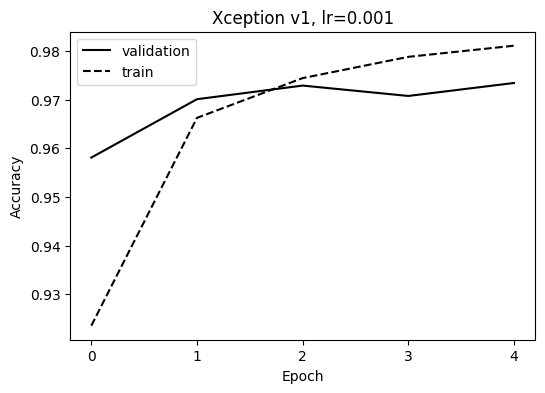

In [101]:
# Строим график также на основе новых данных.
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_001.svg')

plt.show()

In [102]:
model = make_model(learning_rate=0.0001)
history_0_0001 = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
1094/1094 [==============================] - 87s 77ms/step - loss: 0.6374 - accuracy: 0.8006 - val_loss: 0.3701 - val_accuracy: 0.8927
Epoch 2/5
1094/1094 [==============================] - 88s 81ms/step - loss: 0.3073 - accuracy: 0.9115 - val_loss: 0.2591 - val_accuracy: 0.9247
Epoch 3/5
1094/1094 [==============================] - 83s 76ms/step - loss: 0.2317 - accuracy: 0.9346 - val_loss: 0.2093 - val_accuracy: 0.9392
Epoch 4/5
1094/1094 [==============================] - 84s 77ms/step - loss: 0.1919 - accuracy: 0.9452 - val_loss: 0.1788 - val_accuracy: 0.9463
Epoch 5/5
1094/1094 [==============================] - 83s 76ms/step - loss: 0.1659 - accuracy: 0.9520 - val_loss: 0.1589 - val_accuracy: 0.9520


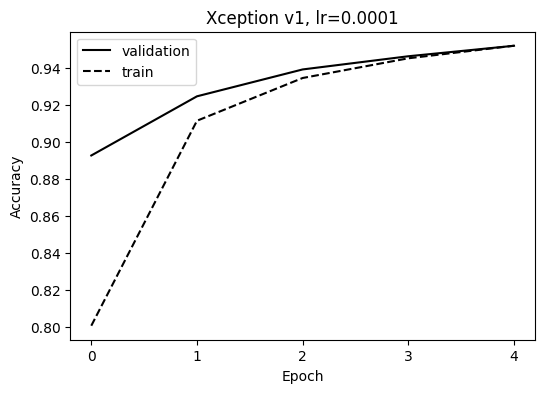

In [103]:
plt.figure(figsize=(6, 4))

epochs = history_0_0001.epoch
val = history_0_0001.history['val_accuracy']
train = history_0_0001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.0001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_0001.svg')

plt.show()

In [104]:
epochs = np.arange(5)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

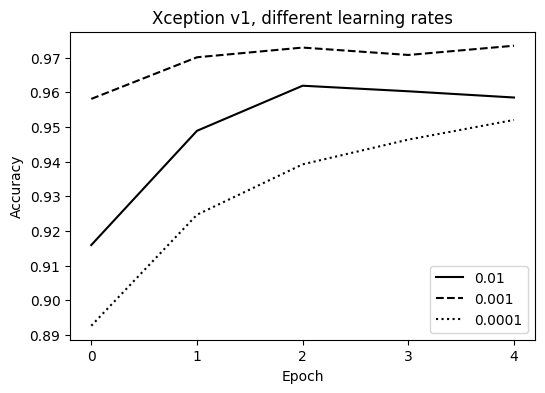

In [105]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('Xception v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('xception_v1_all_lr.svg')

plt.show()

In [106]:
model = make_model(learning_rate=0.001)

# ** Сохранение модели и контрольная точка **

In [107]:
#Как только модель обучена, мы можем ее сохранить.

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5", 
        # сохраняем шаблон {epoch:02d} - номер эпохи который мы выбрали, {val_accuracy:.3f} - заменяется на достоверность при проверке. 
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=callbacks) 
# callback - определяет список обратных вызовов, 
#которые будут использоваться при обучении (callback - checkpoint)

Epoch 1/5
1094/1094 [==============================] - 86s 77ms/step - loss: 0.2388 - accuracy: 0.9243 - val_loss: 0.1312 - val_accuracy: 0.9597
Epoch 2/5
1094/1094 [==============================] - 82s 75ms/step - loss: 0.1079 - accuracy: 0.9657 - val_loss: 0.0953 - val_accuracy: 0.9724
Epoch 3/5
1094/1094 [==============================] - 84s 77ms/step - loss: 0.0819 - accuracy: 0.9742 - val_loss: 0.0862 - val_accuracy: 0.9721
Epoch 4/5
1094/1094 [==============================] - 85s 78ms/step - loss: 0.0685 - accuracy: 0.9779 - val_loss: 0.0815 - val_accuracy: 0.9723
Epoch 5/5
1094/1094 [==============================] - 85s 78ms/step - loss: 0.0598 - accuracy: 0.9808 - val_loss: 0.0768 - val_accuracy: 0.9743


# ** Добавление дополнительных слоёв + регуляризация и отсев**

In [108]:
# У нас нет ограничениё в один слой, поэтому добавим ещё один слой между базовой моделью и последним 
# слоем с прогнозами (между векторным представлением и выводом).

def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector) # Добавляем еще один плотный слой размером 100
    drop = keras.layers.Dropout(droprate)(inner) # Добавляем регуляризацию и отсев

    outputs = keras.layers.Dense(5)(drop) # Вместо подключения к вектору, подключает его к внутреннему. 

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

# Нет особой причины выбирать размер 100 для внутреннего слоя, это просто параметр как и скорость обучения, 
# можно пробовать различные цифры и выяснить какое из них приводит к лучшей производительности при проверке. 
# Отсев- борьба с переобучением нейронных сетей. Суть в замораживании части плотного слоя во время обучения, 
# на каждой итерации "замороженная" часть выбирается случайным образом. Обучается только оставшаяся, "замороженная" не меняется.

In [109]:
# Функция создания модели с отсевом
model = make_model(learning_rate=0.001, droprate=0.0) # ничего не замораживается

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
1094/1094 [==============================] - 88s 79ms/step - loss: 0.1494 - accuracy: 0.9467 - val_loss: 0.0724 - val_accuracy: 0.9742
Epoch 2/10
1094/1094 [==============================] - 82s 75ms/step - loss: 0.0596 - accuracy: 0.9785 - val_loss: 0.0662 - val_accuracy: 0.9751
Epoch 3/10
1094/1094 [==============================] - 83s 76ms/step - loss: 0.0391 - accuracy: 0.9853 - val_loss: 0.0629 - val_accuracy: 0.9795
Epoch 4/10
1094/1094 [==============================] - 86s 79ms/step - loss: 0.0286 - accuracy: 0.9899 - val_loss: 0.0566 - val_accuracy: 0.9801
Epoch 5/10
1094/1094 [==============================] - 86s 79ms/step - loss: 0.0254 - accuracy: 0.9916 - val_loss: 0.0534 - val_accuracy: 0.9820
Epoch 6/10
1094/1094 [==============================] - 83s 76ms/step - loss: 0.0162 - accuracy: 0.9940 - val_loss: 0.0554 - val_accuracy: 0.9801
Epoch 7/10
1094/1094 [==============================] - 83s 76ms/step - loss: 0.0150 - accuracy: 0.9949 - val_loss: 0.0521 -

In [110]:
model = make_model(learning_rate=0.001, droprate=0.2) # замораживается 20% слоя

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
1094/1094 [==============================] - 88s 79ms/step - loss: 0.1678 - accuracy: 0.9409 - val_loss: 0.0879 - val_accuracy: 0.9663
Epoch 2/10
1094/1094 [==============================] - 86s 78ms/step - loss: 0.0725 - accuracy: 0.9730 - val_loss: 0.0703 - val_accuracy: 0.9738
Epoch 3/10
1094/1094 [==============================] - 86s 79ms/step - loss: 0.0514 - accuracy: 0.9810 - val_loss: 0.0589 - val_accuracy: 0.9779
Epoch 4/10
1094/1094 [==============================] - 84s 77ms/step - loss: 0.0422 - accuracy: 0.9840 - val_loss: 0.0458 - val_accuracy: 0.9823
Epoch 5/10
1094/1094 [==============================] - 88s 80ms/step - loss: 0.0333 - accuracy: 0.9879 - val_loss: 0.0603 - val_accuracy: 0.9791
Epoch 6/10
1094/1094 [==============================] - 85s 78ms/step - loss: 0.0319 - accuracy: 0.9878 - val_loss: 0.0675 - val_accuracy: 0.9790
Epoch 7/10
1094/1094 [==============================] - 87s 79ms/step - loss: 0.0259 - accuracy: 0.9907 - val_loss: 0.0458 -

In [111]:
model = make_model(learning_rate=0.001, droprate=0.5) # замораживаем 50% слоя

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
1094/1094 [==============================] - 90s 80ms/step - loss: 0.2319 - accuracy: 0.9177 - val_loss: 0.0877 - val_accuracy: 0.9691
Epoch 2/10
1094/1094 [==============================] - 87s 79ms/step - loss: 0.1108 - accuracy: 0.9588 - val_loss: 0.0690 - val_accuracy: 0.9769
Epoch 3/10
1094/1094 [==============================] - 89s 82ms/step - loss: 0.0886 - accuracy: 0.9668 - val_loss: 0.0658 - val_accuracy: 0.9750
Epoch 4/10
1094/1094 [==============================] - 89s 81ms/step - loss: 0.0770 - accuracy: 0.9709 - val_loss: 0.0561 - val_accuracy: 0.9788
Epoch 5/10
1094/1094 [==============================] - 91s 83ms/step - loss: 0.0650 - accuracy: 0.9756 - val_loss: 0.0522 - val_accuracy: 0.9801
Epoch 6/10
1094/1094 [==============================] - 93s 85ms/step - loss: 0.0631 - accuracy: 0.9761 - val_loss: 0.0519 - val_accuracy: 0.9822
Epoch 7/10
1094/1094 [==============================] - 96s 88ms/step - loss: 0.0552 - accuracy: 0.9794 - val_loss: 0.0483 -

In [112]:
model = make_model(learning_rate=0.001, droprate=0.8) # замораживаем 80% слоя

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
1094/1094 [==============================] - 94s 84ms/step - loss: 0.4956 - accuracy: 0.8019 - val_loss: 0.1502 - val_accuracy: 0.9488
Epoch 2/10
1094/1094 [==============================] - 94s 86ms/step - loss: 0.3071 - accuracy: 0.8765 - val_loss: 0.1178 - val_accuracy: 0.9554
Epoch 3/10
1094/1094 [==============================] - 92s 84ms/step - loss: 0.2576 - accuracy: 0.8968 - val_loss: 0.1055 - val_accuracy: 0.9581
Epoch 4/10
1094/1094 [==============================] - 92s 84ms/step - loss: 0.2325 - accuracy: 0.9058 - val_loss: 0.0902 - val_accuracy: 0.9665
Epoch 5/10
1094/1094 [==============================] - 91s 83ms/step - loss: 0.2156 - accuracy: 0.9141 - val_loss: 0.0805 - val_accuracy: 0.9703
Epoch 6/10
1094/1094 [==============================] - 93s 85ms/step - loss: 0.2102 - accuracy: 0.9144 - val_loss: 0.0761 - val_accuracy: 0.9696
Epoch 7/10
1094/1094 [==============================] - 99s 90ms/step - loss: 0.1985 - accuracy: 0.9198 - val_loss: 0.0736 -

In [113]:
epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']

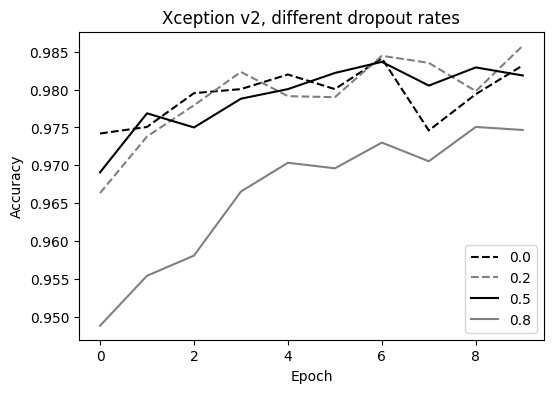

In [114]:
# Строим график
# Из результатов на проверочном наборе видно, что нет существенной разницы между 0 - 0.5 . Однако с 0.8 ситуация хуже, 
# сети стало действительно трудно чему-либо научиться. Достоверность на проверочном наборе аналогична для коэфф-ов 0 - 0.5. 
# Для 0.8 также хуже. 
# Без отсева модель быстро запоминает весь обучающий набор данных и через 5 эпох становится достоверной на 99.9 %. 
# При коэфф.отсева 0.2 требуется больше времени для переобучения на обучающем наборе данных, при 0.5 модель не достигает
# идеальной достоверности даже после 10 итераций, установив коэфф. 0.8 мы существенно затрудняем 
# обучение сети, поэтому достоверность невелика даже на обучающем наборе данных. 
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout.svg')

plt.show()

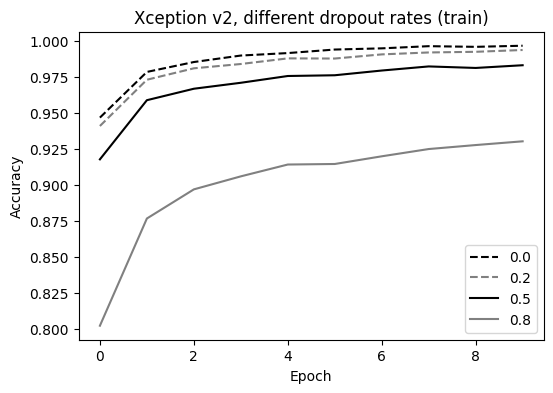

In [115]:
# При коэфф.отсева 0.5 сеть уже не переобучается настолько быстро, сохраняя 
# уровень достоверности. Предпочтём её.

plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout_train.svg')

plt.show()

# **Расширение данных**

In [116]:
# Чем больше данных - тем лучше для повышения качества модели. Не всегда есть возможность увеличить 
# исходное количество данных, но мы можем сгенерировать больший объём информации. Например:
#  * Отразить изображение по вертикали и горизонтали
#  * Повернуть изображение
#  * Увеличить или уменьшить масштаб
#  * Изменить изображение другими способами

validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "C:/Users/dj_ar/OneDrive/Рабочий стол/GB_AI/2 Project/dataset AI/test",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 15000 images belonging to 5 classes.


In [117]:
# rotation_range=30 - повернуть изображение на произвольный градус от -30 до 30 
# width_shit_range=30 - сместить изображение по горизонтали на величину от -30 до 30 пикселей
# height_shift_range=30 - сместить изображение по вертикали на величину от -30 до 30 пикселей
# shear_range=-10 - применить сдвиг значение от -10 до 10 пикселей
# zoom_range=0.2 - применить масштабирование, используя коэфф.масштабирования от 0.8 до 1.2
# horizontal_flip=true - случайно отразить изображение по горизонтали
# vertical_flip=false - не отображать изображение вертикально 

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=5.0,
    zoom_range=0.1,
    horizontal_flip=True,
)

#Так же как и ранее используем генератор(ссылка на локальное расположение датасета)

train_ds = train_gen.flow_from_directory(
    "C:/Users/dj_ar/OneDrive/Рабочий стол/GB_AI/2 Project/dataset AI/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 35000 images belonging to 5 classes.


In [118]:
# Обучаем новую модель, ставим также 10 эпох.

model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v3_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
1094/1094 [==============================] - 179s 161ms/step - loss: 0.1898 - accuracy: 0.9301 - val_loss: 0.1141 - val_accuracy: 0.9583
Epoch 2/10
1094/1094 [==============================] - 180s 164ms/step - loss: 0.0931 - accuracy: 0.9660 - val_loss: 0.0719 - val_accuracy: 0.9751
Epoch 3/10
1094/1094 [==============================] - 183s 167ms/step - loss: 0.0722 - accuracy: 0.9735 - val_loss: 0.0612 - val_accuracy: 0.9780
Epoch 4/10
1094/1094 [==============================] - 177s 162ms/step - loss: 0.0651 - accuracy: 0.9753 - val_loss: 0.0604 - val_accuracy: 0.9773
Epoch 5/10
1094/1094 [==============================] - 184s 168ms/step - loss: 0.0590 - accuracy: 0.9782 - val_loss: 0.0538 - val_accuracy: 0.9794
Epoch 6/10
1094/1094 [==============================] - 180s 165ms/step - loss: 0.0503 - accuracy: 0.9805 - val_loss: 0.0502 - val_accuracy: 0.9810
Epoch 7/10
1094/1094 [==============================] - 183s 168ms/step - loss: 0.0524 - accuracy: 0.9800 - val_

In [119]:
epochs = history.epoch
accuracy = history.history['val_accuracy']

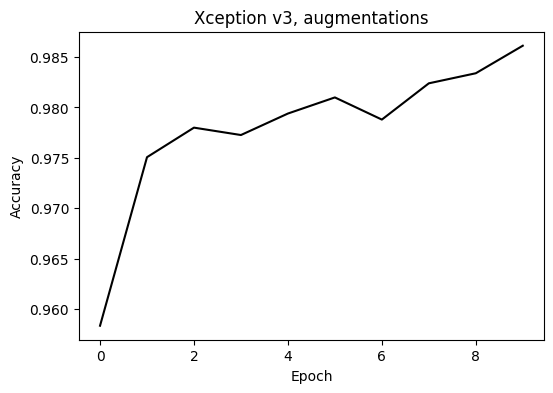

In [120]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, accuracy, color='black', linestyle='solid')


plt.title('Xception v3, augmentations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('xception_v3_aug.svg')

plt.show()

In [121]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(299, 299, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(5)(drop)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

In [122]:
image_size = (299, 299)
batch_size = 32

In [123]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=5.0,
    zoom_range=0.1,
    horizontal_flip=True,
)

train_ds = train_gen.flow_from_directory(
    "C:/Users/dj_ar/OneDrive/Рабочий стол/GB_AI/2 Project/dataset AI/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 35000 images belonging to 5 classes.


In [124]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "C:/Users/dj_ar/OneDrive/Рабочий стол/GB_AI/2 Project/dataset AI/test",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 15000 images belonging to 5 classes.


In [125]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v4_large_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_l = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
1094/1094 [==============================] - 495s 450ms/step - loss: 0.1691 - accuracy: 0.9390 - val_loss: 0.0675 - val_accuracy: 0.9778
Epoch 2/10
1094/1094 [==============================] - 495s 452ms/step - loss: 0.0720 - accuracy: 0.9750 - val_loss: 0.0504 - val_accuracy: 0.9817
Epoch 3/10
1094/1094 [==============================] - 492s 449ms/step - loss: 0.0559 - accuracy: 0.9806 - val_loss: 0.0440 - val_accuracy: 0.9854
Epoch 4/10
1094/1094 [==============================] - 490s 448ms/step - loss: 0.0426 - accuracy: 0.9846 - val_loss: 0.0387 - val_accuracy: 0.9853
Epoch 5/10
1094/1094 [==============================] - 480s 439ms/step - loss: 0.0402 - accuracy: 0.9854 - val_loss: 0.0281 - val_accuracy: 0.9905
Epoch 6/10
1094/1094 [==============================] - 495s 452ms/step - loss: 0.0349 - accuracy: 0.9877 - val_loss: 0.0287 - val_accuracy: 0.9905
Epoch 7/10
1094/1094 [==============================] - 492s 450ms/step - loss: 0.0335 - accuracy: 0.9881 - val_

# **Распознавание и прогноз **

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
# Сортируем по классам обучения.

labels = {
    0: '0 класс',
    1: '1 класс',
    2: '2 класс',
    3: '3 класс',
    4: '4 класс'
}

In [28]:
image_size = (299, 299)

In [29]:
#Загружаем нашу обученную модель(можно воспользоваться шаблоном, который указывали выше, 
# можно прямой ссылкой - в нашем случае)
#model = keras.models.load_model("xception_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.h5")
#model = keras.models.load_model('xception_v4_large_08_0.894.h5')
model = keras.models.load_model("xception_v4_large_08_0.992.h5")

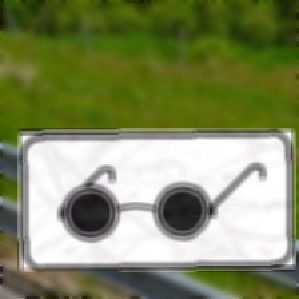

In [41]:
# Загружаем нашу модель и отображаем
# path = "C:/Users/dj_ar/OneDrive/Рабочий стол/GB_AI/2 Project/dataset AI/test/4/4_7172.png"
path = "C:/Users/dj_ar/OneDrive/Рабочий стол/GB_AI/2 Project\dataset AI/train/8/8_26.png"
img = load_img(path, target_size=(image_size))
img

In [42]:
#Предварительно обрабатываем изображения
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [43]:
# Смотрим вероятность прогноза модели для каждого класса
pred = model.predict(X)
pred[0]

1/1 [==============================] - 0s 21ms/step


array([-16.628378 ,  -1.176282 ,  -7.7165704, -16.608074 ,  20.210337 ],
      dtype=float32)

In [44]:
# Получаем прогноз по номеру класса указанному выше(выбирает наиболее вероятный из всех).
# В нашей случае это 4 класс
pred[0].argmax()

4

In [34]:
#Для загрузки тестовых данных следуем тому же подходу, используем ImageDataGenerator
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    "C:/Users/dj_ar/OneDrive/Рабочий стол/GB_AI/2 Project/dataset AI/test",
    shuffle=False,
    target_size=image_size,
    batch_size=32,
)

Found 15000 images belonging to 5 classes.


In [35]:
# Оцениваем модель
# В данном случае наша модель показывает точность 99% (если мы повторим процесс для малого набора данных,
# то увидим, что поризводительность ухудшилась до 75%)
model.evaluate(test_ds)

469/469 [==============================] - 49s 103ms/step - loss: 0.0228 - accuracy: 0.9921


[0.02281920611858368, 0.9921333193778992]